In [96]:
#read in data
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import json
import os 

In [97]:
# Define servo indices (as you've already done)
servoIndices = {
    "Tilt": 0,
    "Pan": 1,
    "LeftEye": 2,
    "RightEye": 3,
    "LeftPupil": 4,
    "RightPupil": 5,
    "LeftArmJoint1": 6,
    "LeftArmJoint2": 7,
    "LeftArmJoint3": 8,
    "LeftArmJoint4": 9,
    "LeftArmJoint5": 10,
    "LeftHand": 11,
    "RightArmJoint1": 12,
    "RightArmJoint2": 13,
    "RightArmJoint3": 14,
    "RightArmJoint4": 15,
    "RightArmJoint5": 16,
    "RightHand": 17,
    "Body": 18
}

def parse_array(values):
    return np.array(values)

def read_data_json(file, goal_positions_file=None):
    # Initialize an empty DataFrame with required columns
    df = pd.DataFrame(columns=['UniqueID', 'Trajectory', 'Current', 'GyroX', 'GyroY', 'GyroZ', 'AccelX', 'AccelY', 'AccelZ'])
    
    with open(file) as f:
        data = json.load(f)
    
    # Load goal positions if file is provided
    goal_positions_dict = {}
    if goal_positions_file:
        with open(goal_positions_file) as f:
            # Load the entire file as a single JSON object
            goal_positions_data = json.load(f)
            
            # Check if the data is in the expected format with a "Mapping" key
            if "Mapping" in goal_positions_data:
                mapping_data = goal_positions_data["Mapping"]
            else:
                mapping_data = goal_positions_data
            
            # Process each entry in the goal positions data
            for entry in mapping_data:
                if isinstance(entry, dict) and "UniqueID" in entry:
                    # Store goal position for this unique ID
                    unique_id = entry["UniqueID"][0]  # Extract the first (and only) element from the UniqueID array
                    # Check if GoalPosition exists in the entry
                    if "GoalPosition" in entry:
                        goal_positions_dict[unique_id] = parse_array(entry["GoalPosition"])
    
    # Extract data for each trajectory
    all_rows = []
    for traj in data['Trajectories']:
        unique_id = traj['UniqueID']
        trajectory = parse_array(traj['Trajectory'])
        current = parse_array(traj['Current'])
        gyro = parse_array(traj['Gyro'])
        accel = parse_array(traj['Accel'])
        
        # Get goal position for this trajectory if available
        goal_position = goal_positions_dict.get(unique_id, None)
        
        # For each point in the trajectory, create a single row with individual values
        for i in range(len(trajectory)):
            row = {
                'UniqueID': unique_id,
                'GyroX': gyro[i, 0],
                'GyroY': gyro[i, 1],
                'GyroZ': gyro[i, 2],
                'AccelX': accel[i, 0],
                'AccelY': accel[i, 1],
                'AccelZ': accel[i, 2]
            }
            
            # Add individual columns for each servo's trajectory and current
            for servo_name, servo_idx in servoIndices.items():
                if servo_idx < trajectory.shape[1]:
                    row[f'{servo_name}Pos'] = trajectory[i][servo_idx]
                if servo_idx < current.shape[1]:
                    row[f'{servo_name}Current'] = current[i][servo_idx]
                
                # Add distance to goal for each servo position if goal position is available
                if goal_position is not None and servo_idx < len(goal_position):
                    if servo_idx < trajectory.shape[1]:
                        row[f'{servo_name}DistToGoal'] = abs(goal_position[servo_idx] - trajectory[i][servo_idx])
            
            all_rows.append(row)
    
    # Create a DataFrame from the collected rows
    df = pd.DataFrame(all_rows)

    return df
# Example usage
df = read_data_json("data/TrajectoriesTorso.json", "data/CurrentPositionMappingTorso.json")


In [98]:
df.head()

,UniqueID,GyroX,GyroY,GyroZ,AccelX,AccelY,AccelZ,TiltPos,TiltCurrent,TiltDistToGoal,PanPos,PanCurrent,PanDistToGoal
0,699873,-0.46,0.49,-0.43,0.00,0.00,0.00,176.35,0.00,16.35,192.35,0.00,6.35
1,699873,-0.07,0.58,0.00,0.23,-0.03,-0.94,176.35,0.00,16.35,192.35,0.00,6.35
2,699873,-0.03,0.55,0.64,0.23,-0.03,-0.94,176.35,-23.52,16.35,192.35,-23.52,6.35
3,699873,-1.10,0.67,0.52,0.23,-0.03,-0.94,176.44,-26.88,16.44,192.35,-26.88,6.35
4,699873,-0.46,-0.09,1.12,0.23,-0.03,-0.94,176.35,-26.88,16.35,192.35,-26.88,6.35


In [134]:
def standardize_data(df, save_path='data/mean_std.json'):
    """
    Standardize all columns in the dataframe except UniqueID.
    
    Args:
        df: DataFrame to standardize
        save_path: Path to save the means and standard deviations as JSON
        
    Returns:
        Standardized DataFrame and dictionary of means and standard deviations
    """
    # First, make a copy of the original dataframe
    std_df = df.copy()

    # Get all columns except UniqueID
    columns_to_standardize = [col for col in std_df.columns if col != 'UniqueID']

    means_and_stds = {}

    # Apply standardization (z-score normalization) to each column
    for column in columns_to_standardize:
        # Initialize the dictionary for each column
        means_and_stds[column] = []
        
        mean_val = std_df[column].mean()
        std_val = std_df[column].std()
        
        # Store the mean and std for each column as dictionary
        means_and_stds[column] = {"mean": mean_val, "std": std_val}
        
        # Check if standard deviation is not zero to avoid division by zero
        if std_val > 0:
            std_df[column] = round((std_df[column] - mean_val) / std_val, 3)
        else:
            print(f"Warning: Column {column} has zero standard deviation. Skipping standardization.")

    print(f"Standardized {len(columns_to_standardize)} columns.")

    
    with open(save_path, 'w') as f:
        json.dump(means_and_stds, f, indent=4)
        
    return std_df, means_and_stds


In [135]:
# Call the function to standardize the data
std_df, means_and_stds = standardize_data(df, 'data/all_mean_std.json')
std_df.head()

Standardized 12 columns.


,UniqueID,GyroX,GyroY,GyroZ,AccelX,AccelY,AccelZ,TiltPos,TiltCurrent,TiltDistToGoal,PanPos,PanCurrent,PanDistToGoal
0,699873,-0.027,-0.032,-0.020,0.050,0.087,2.872,-0.316,-0.065,-0.991,0.024,0.288,0.094
1,699873,0.012,-0.028,0.006,0.405,-0.009,-1.551,-0.316,-0.065,-0.991,0.024,0.288,0.094
2,699873,0.016,-0.029,0.045,0.405,-0.009,-1.551,-0.316,-0.117,-0.991,0.024,-0.172,0.094
3,699873,-0.092,-0.023,0.038,0.405,-0.009,-1.551,-0.314,-0.124,-0.988,0.024,-0.238,0.094
4,699873,-0.027,-0.062,0.075,0.405,-0.009,-1.551,-0.316,-0.124,-0.991,0.024,-0.238,0.094


In [136]:
#save the standardized dataframe
std_df.to_csv('data/standardized_data.csv', index=False)

In [137]:
def approximating_goal_filter(df, servo=None):
    """
    Filter data to only include rows where the servo is approaching its goal.
    
    Args:
        df: DataFrame containing the data
        servo: String indicating which servo to analyze (e.g., 'Tilt', 'Pan')
        
    Returns:
        DataFrame containing only rows where the servo is approaching its goal
    """
    # Check if servo parameter is provided
    if servo is None:
        print("Error: servo parameter is required (e.g., 'Tilt' or 'Pan')")
        return pd.DataFrame()
    
    # Create the column name for goal approaching flag
    goal_approaching_col = f'{servo}GoalApproaching'
    
    # Initialize result dataframe
    filtered_df = pd.DataFrame()
    
    # Get unique IDs more efficiently
    grouped = df.groupby('UniqueID')
    
    # Process each group
    for uid, group in grouped:
        # Skip if we have only one row for this ID
        if len(group) <= 1:
            continue
        
        # Make a copy to avoid SettingWithCopyWarning
        uid_data = group.copy()
        
        # Calculate if DistToGoal is decreasing (vectorized operation)
        dist_col = f'{servo}DistToGoal'
        uid_data[goal_approaching_col] = False
        
        # Get absolute distances
        abs_distances = uid_data[dist_col].abs().values
        
        # Compare current with previous (shifted) values
        approaching = abs_distances[1:] < abs_distances[:-1]
        
        # Set the flag for rows where distance is decreasing
        # Skip first row (index 0) as it has no previous value to compare with
        uid_data.iloc[1:, uid_data.columns.get_loc(goal_approaching_col)] = approaching
        
        # Filter rows where the servo is approaching the goal
        approximating = uid_data[uid_data[goal_approaching_col] == True]
        
        # Append to filtered dataframe
        if not approximating.empty:
            filtered_df = pd.concat([filtered_df, approximating])
    
    # Drop the temporary column we added
    if not filtered_df.empty and goal_approaching_col in filtered_df.columns:
        filtered_df = filtered_df.drop(columns=[goal_approaching_col])
    
    # Print summary
    print(f"Original data: {len(df)} rows")
    print(f"Filtered data: {len(filtered_df)} rows")
    
    # Display a few rows from filtered dataset
    print("\nFiltered data sample:")
    if not filtered_df.empty:
        display(filtered_df.head())
    else:
        print("No data matched the filter criteria.")
    
    return filtered_df


In [202]:
def approximating_goal_filter(df, servo=None):
    """
    Filter data to only include rows where the servo is approaching its goal.
    Optimized for performance using vectorized operations.
    
    Args:
        df: DataFrame containing the data
        servo: String indicating which servo to analyze (e.g., 'Tilt', 'Pan')
        
    Returns:
        DataFrame containing only rows where the servo is approaching its goal
    """
    # Check if servo parameter is provided
    if servo is None:
        print("Error: servo parameter is required (e.g., 'Tilt' or 'Pan')")
        return pd.DataFrame()
    
    # Create the column name for distance to goal
    dist_col = f'{servo}DistToGoal'
    
    # Check if the distance column exists
    if dist_col not in df.columns:
        print(f"Error: {dist_col} column not found in the dataframe")
        return pd.DataFrame()
    
    # Initialize result dataframe
    result_dfs = []
    
    # Process each unique ID group
    for uid, group in df.groupby('UniqueID'):
        # Skip if we have only one row for this ID
        if len(group) <= 1:
            continue
        
        # Calculate absolute distances
        abs_distances = group[dist_col].abs().values
        
        # Create a boolean mask for rows where distance is decreasing
        # First row can't be approaching (no previous value to compare)
        is_approaching = np.zeros(len(group), dtype=bool)
        
        # Set True where current distance is less than previous row
        is_approaching[1:] = abs_distances[1:] < abs_distances[:-1]
        
        # Filter the group using the mask
        approaching_rows = group[is_approaching]
        
        # Add to results if not empty
        if not approaching_rows.empty:
            result_dfs.append(approaching_rows)
    
    # Combine all filtered groups
    if result_dfs:
        filtered_df = pd.concat(result_dfs)
    else:
        filtered_df = pd.DataFrame()
    
    # Print summary
    print(f"Original data: {len(df)} rows")
    print(f"Filtered data: {len(filtered_df)} rows")
    
    # Display a few rows from filtered dataset
    print("\nFiltered data sample:")
    if not filtered_df.empty:
        display(filtered_df.head())
    else:
        print("No data matched the filter criteria.")
    
    return filtered_df

In [203]:
tilt_filtered_df = approximating_goal_filter(df, 'Tilt')
pan_filtered_df = approximating_goal_filter(df, 'Pan')

Original data: 700867 rows
Filtered data: 156761 rows

Filtered data sample:


,UniqueID,GyroX,GyroY,GyroZ,AccelX,AccelY,AccelZ,TiltPos,TiltCurrent,TiltDistToGoal,PanPos,PanCurrent,PanDistToGoal
698204,57126,0.00,0.00,0.00,0.00,0.00,0.00,247.38,0.00,119.38,213.89,0.00,41.89
698206,57126,0.00,0.00,0.00,0.00,0.00,0.00,247.38,-26.88,119.38,213.98,-23.52,41.98
698215,57126,0.55,-0.21,8.54,-0.78,-0.36,-0.44,247.38,-43.68,119.38,213.54,-43.68,41.54
698219,57126,-1.31,-0.27,5.47,-0.78,-0.35,-0.44,247.38,-53.76,119.38,213.45,-53.76,41.45
698224,57126,-4.15,1.55,29.14,-0.79,-0.35,-0.43,247.38,-60.48,119.38,212.48,-63.84,40.48


Original data: 700867 rows
Filtered data: 138785 rows

Filtered data sample:


,UniqueID,GyroX,GyroY,GyroZ,AccelX,AccelY,AccelZ,TiltPos,TiltCurrent,TiltDistToGoal,PanPos,PanCurrent,PanDistToGoal
698207,57126,0.04,1.25,-0.12,-0.78,-0.35,-0.44,247.38,-26.88,119.38,213.89,-26.88,41.89
698210,57126,-2.96,-1.37,4.29,-0.78,-0.36,-0.44,247.38,-33.60,119.38,213.80,-30.24,41.80
698212,57126,-0.59,-0.43,4.64,-0.78,-0.35,-0.44,247.38,-36.96,119.38,213.71,-33.60,41.71
698213,57126,2.15,0.03,2.62,-0.78,-0.35,-0.44,247.38,-40.32,119.38,213.63,-40.32,41.63
698215,57126,0.55,-0.21,8.54,-0.78,-0.36,-0.44,247.38,-43.68,119.38,213.54,-43.68,41.54


In [174]:
def plot_distance_to_goal(df, servo):
    """
    Plot DistToGoal for a random UniqueID from the dataframe.
    
    Args:
        df: Pandas DataFrame containing the data
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import random

    # Get a list of unique IDs from the standardized dataframe
    unique_ids = df['UniqueID'].unique()
    dist_col = f'{servo}DistToGoal'

    # Select a random UniqueID
    random_id = random.choice(unique_ids)

    # Filter data for the selected UniqueID
    id_data = df[df['UniqueID'] == random_id].copy()

    # Create a sequence number for x-axis (representing time steps)
    id_data['Sequence'] = np.arange(len(id_data))

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(id_data['Sequence'], id_data[dist_col], marker='o', linestyle='-', color='blue')

    # Add a horizontal line at y=0 for reference
    plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)

    # Add labels and title
    plt.xlabel('Time Sequence')
    plt.ylabel(dist_col)
    plt.title(f'{dist_col} Over Time for UniqueID: {random_id}')

    # Add grid for better readability
    plt.grid(True, alpha=0.3)

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Display some statistics about this sequence
    print(f"Statistics for UniqueID {random_id}:")
    print(f"Number of data points: {len(id_data)}")
    print(f"Initial {dist_col}: {id_data[dist_col].iloc[0]:.4f}")
    print(f"Final {dist_col}: {id_data[dist_col].iloc[-1]:.4f}")
    print(f"Min {dist_col}: {id_data[dist_col].min():.4f}")
    print(f"Max {dist_col}: {id_data[dist_col].max():.4f}")


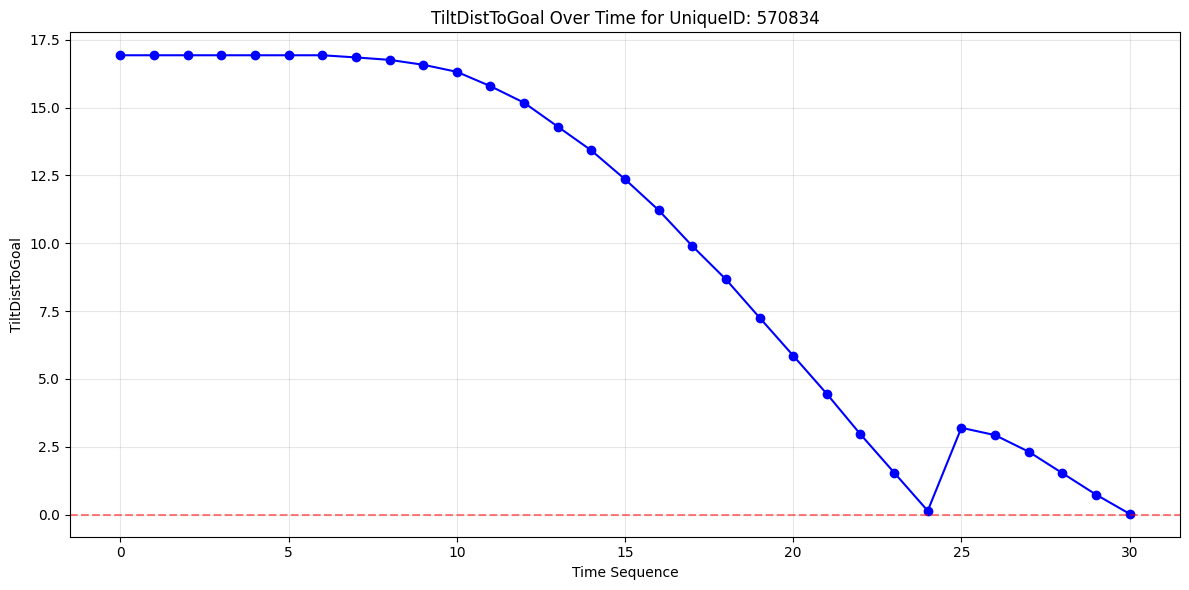

Statistics for UniqueID 570834:
Number of data points: 31
Initial TiltDistToGoal: 16.9300
Final TiltDistToGoal: 0.0300
Min TiltDistToGoal: 0.0300
Max TiltDistToGoal: 16.9300


In [214]:
plot_tilt_distance_to_goal(tilt_filtered_df)

In [139]:
#standardize the filtered data
tilt_filtered_df, tilt_means_and_stds = standardize_data(tilt_filtered_df, 'data/tilt_mean_std.json')
pan_filtered_df, pan_means_and_stds = standardize_data(pan_filtered_df, 'data/pan_mean_std.json')
#save the filtered data
tilt_filtered_df.to_csv('data/tilt_filtered_data.csv', index=False)
pan_filtered_df.to_csv('data/pan_filtered_data.csv', index=False)


Standardized 12 columns.
Standardized 12 columns.


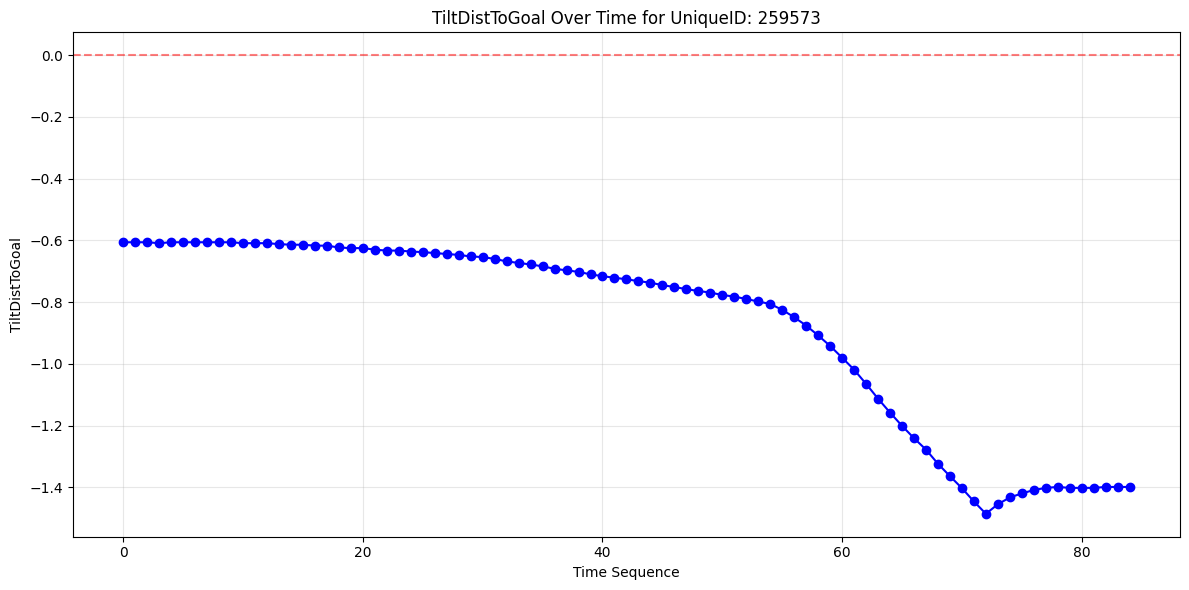

Statistics for UniqueID 259573:
Number of data points: 85
Initial TiltDistToGoal: -0.6060
Final TiltDistToGoal: -1.3990
Min TiltDistToGoal: -1.4860
Max TiltDistToGoal: -0.6060
